In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical



2023-04-01 12:36:55.516323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Read the CSV file into a pandas dataframe
df = pd.read_csv('internship_assignment.csv')

# Convert the 'dt' column to a datetime format
df['dt'] = pd.to_datetime(df['dt'])

# Extract features from 'dt' column
df['day_of_week'] = df['dt'].dt.dayofweek
df['hour_of_day'] = df['dt'].dt.hour


# Drop unnecessary columns
df = df.drop(columns=['dt', 'selected_track_id', 'selected_project_id', 'step_id'])

# Sort the data by 'user_id_hashed' columns in ascending order
df = df.sort_values(['user_id_hashed'], ascending=True)




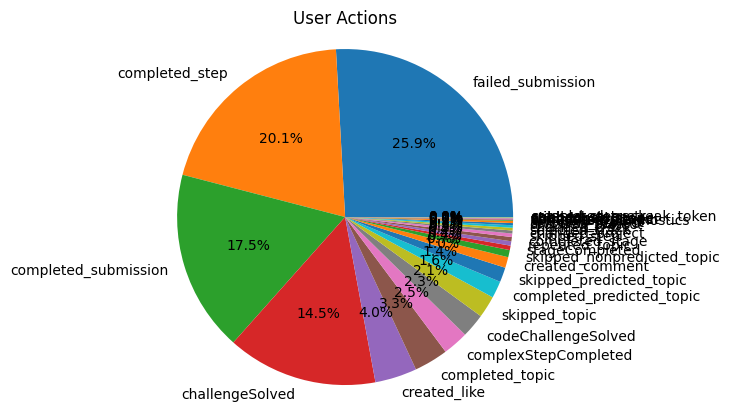

In [26]:
import matplotlib.pyplot as plt
action_counts = df['action'].value_counts()

# Create a pie chart
plt.pie(action_counts.values, labels=action_counts.index, autopct='%1.1f%%')
plt.title('User Actions')
plt.axis('equal')
plt.show()

In [19]:
# Define a list of the categorical column names
categorical_columns = ['user_id_hashed', 'learning_goal', 'selected_project', 'topic', 'project', 'project_difficulty', 'step', 'step_difficulty']

# Define an instance of the OneHotEncoder class for encoding categorical variables
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the categorical columns in one step
encoded_categorical_data = encoder.fit_transform(df[categorical_columns])

# Combine the non-categorical columns and 'user_id_hashed' with the encoded categorical data
non_categorical_columns = ['day_of_week', 'hour_of_day']
encoded_data = pd.concat([df[non_categorical_columns], df['user_id_hashed'], pd.DataFrame(encoded_categorical_data.toarray())], axis=1)




# One-hot encode the target variable 'action'
target_encoder = OneHotEncoder(handle_unknown='ignore')
encoded_target = target_encoder.fit_transform(df[['action']])

# Normalize the non-categorical columns using MinMaxScaler
scaler = MinMaxScaler()
encoded_data[['day_of_week', 'hour_of_day']] = scaler.fit_transform(encoded_data[['day_of_week', 'hour_of_day']])

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(encoded_data, encoded_target, test_size=0.2, random_state=42)

# Convert the sparse matrix to a dense NumPy array and get the index of the non-zero element
y_train = y_train.toarray().argmax(axis=1)
y_test = y_test.toarray().argmax(axis=1)

# Convert the target variables to one-hot encoded format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

n_features = X_train.shape[1]
n_actions = y_train.shape[1]



In [13]:
# Increase the number of hidden units and LSTM layers
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(1, n_features), return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(Dense(n_actions, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape the input data to be 3D, as required by the LSTM model (samples, timesteps, features)
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_test_reshaped, y_test), verbose=1)  # Increase epochs to 50



Epoch 1/50
762/762 [==============================] - 40s 48ms/step - loss: 1.6860 - accuracy: 0.4638 - val_loss: 1.3839 - val_accuracy: 0.5486
Epoch 2/50
762/762 [==============================] - 37s 48ms/step - loss: 1.2288 - accuracy: 0.6006 - val_loss: 1.2875 - val_accuracy: 0.5878
Epoch 3/50
762/762 [==============================] - 36s 47ms/step - loss: 1.0802 - accuracy: 0.6393 - val_loss: 1.2476 - val_accuracy: 0.6022
Epoch 4/50
762/762 [==============================] - 35s 46ms/step - loss: 0.9543 - accuracy: 0.6739 - val_loss: 1.2373 - val_accuracy: 0.6201
Epoch 5/50
762/762 [==============================] - 36s 47ms/step - loss: 0.8420 - accuracy: 0.7043 - val_loss: 1.1986 - val_accuracy: 0.6227
Epoch 6/50
762/762 [==============================] - 37s 48ms/step - loss: 0.7534 - accuracy: 0.7330 - val_loss: 1.2337 - val_accuracy: 0.6252
Epoch 7/50
527/762 [===================>..........] - ETA: 11s - loss: 0.6831 - accuracy: 0.7518

KeyboardInterrupt: 

In [20]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

def predict_next_actions(model, user_data, n_actions):
    padding_length = model.input_shape[2] - user_data.shape[1]
    user_data_padded = np.pad(user_data.values, ((0, 0), (padding_length, 0)), 'constant')
    user_data_reshaped = user_data_padded.reshape((1, 1, user_data_padded.shape[1]))
    predictions = []

    for _ in range(n_actions):
        prediction = model.predict(user_data_reshaped)
        predictions.append(prediction)
        prediction = prediction.reshape(1, 1, -1)  # Add an extra dimension to the prediction array
        user_data_reshaped = np.concatenate((user_data_reshaped[:, :, :-prediction.shape[2]], prediction), axis=2)

    return np.array(predictions)



191/191 [==============================] - 1s 5ms/step - loss: 1.2627 - accuracy: 0.6339
Test accuracy: 63.39%


In [27]:
user_id = 782347178622731989
user_data = encoded_data[encoded_data['user_id_hashed'] == user_id].iloc[-1:].drop(columns=['user_id_hashed'])

# Predict the next 5 actions for the given user
predicted_actions_encoded = predict_next_actions(model, user_data, 10)

# Decode the predicted actions
predicted_actions = target_encoder.inverse_transform(predicted_actions_encoded.reshape(predicted_actions_encoded.shape[0], -1))
print(f"Next 5 actions for user {user_id}: {predicted_actions}")



1/1 [==============================] - 0s 21ms/step
Next 5 actions for user 782347178622731989: [['codeChallengeSolved']
 ['codeChallengeSolved']
 ['codeChallengeSolved']
 ['codeChallengeSolved']
 ['codeChallengeSolved']
 ['codeChallengeSolved']
 ['codeChallengeSolved']
 ['codeChallengeSolved']
 ['codeChallengeSolved']
 ['codeChallengeSolved']]


In [28]:
# Function to predict the next n actions for a given user data
def predict_next_actions_for_each_user(model, encoded_data, n_actions=5):
    unique_users = encoded_data['user_id_hashed'].unique()
    predictions = {}

    for user_id in unique_users:
        user_data = encoded_data[encoded_data['user_id_hashed'] == user_id].iloc[-1:].drop(columns=['user_id_hashed'])
        predicted_actions_encoded = predict_next_actions(model, user_data, n_actions)
        predicted_actions = target_encoder.inverse_transform(predicted_actions_encoded.reshape(predicted_actions_encoded.shape[0], -1))
        predictions[user_id] = predicted_actions

    return predictions

# Predict the next 5 actions for each unique user
next_actions_for_each_user = predict_next_actions_for_each_user(model, encoded_data, 5)

# Print the predictions
for user_id, actions in next_actions_for_each_user.items():
    print(f"Next 5 actions for user {user_id}: {actions}")


1/1 [==============================] - 0s 22ms/step
Next 5 actions for user 782347178622731989: [['codeChallengeSolved']
 ['codeChallengeSolved']
 ['codeChallengeSolved']
 ['codeChallengeSolved']
 ['codeChallengeSolved']]
Next 5 actions for user 2911199505101500553: [['completed_submission']
 ['completed_submission']
 ['completed_submission']
 ['completed_submission']
 ['completed_submission']]
Next 5 actions for user 3016752473480896665: [['codeChallengeSolved']
 ['codeChallengeSolved']
 ['codeChallengeSolved']
 ['codeChallengeSolved']
 ['codeChallengeSolved']]
Next 5 actions for user 3709264465427925985: [['completed_submission']
 ['completed_submission']
 ['completed_submission']
 ['completed_submission']
 ['completed_submission']]
Next 5 actions for user 4534275443679530850: [['completed_step']
 ['failed_submission']
 ['completed_step']
 ['failed_submission']
 ['completed_step']]
Next 5 actions for user 6005434371571979741: [['failed_submission']
 ['failed_submission']
 ['failed_su